<a href="https://colab.research.google.com/github/NohemiVargas/Procesamiento_y_clasificacion_datos/blob/main/practica3/Practice_3_Maternity_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Práctica Random Forest 1. Maternity Risk identification
Laura Nohemí Vargas de la Rosa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [37]:
# Data treatment
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Graphs
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Pre processing and modeling
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Exploratory Analysis

#### Read the file

In [38]:
data=pd.read_csv('/content/drive/MyDrive/Colaboratory/Procesamiento y clasificación de Datos/Tarea 1/Maternal Health Risk Data Set.csv')

#### First 4 values

In [39]:
data.head(4)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk


#### Column type

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


#### Number of observations and null values

#####Dataset dimensions



In [41]:
data.shape

(1014, 7)

#####Null observations per variable

In [29]:
data.isna().sum().sort_values()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

#### Numerical variables

#####Descriptive statistics for numerical variables

In [30]:
data.select_dtypes(include=['float64', 'int']).describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775,1.867850
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702,0.807353
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000,1.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,1.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,2.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000,3.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000,3.000000


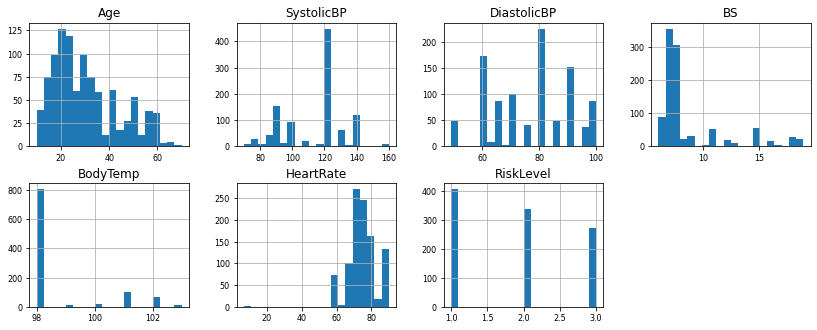

In [31]:
numerical=data.select_dtypes(include=[np.number]).columns.tolist()
data[numerical].hist(bins=20, figsize=(14, 20), layout=(7, 4), xlabelsize=8, ylabelsize=8);

#####Correlation


In [32]:
def tidy_corr_matrix(corr_mat):
    '''
    Function to convert a pandas correlation matrix in tidy format
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

data2 = data.drop('RiskLevel', axis=1)

corr_matrix =  data2.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)


,variable_1,variable_2,r,abs_r
13,DiastolicBP,SystolicBP,0.787006,0.787006
8,SystolicBP,DiastolicBP,0.787006,0.787006
18,BS,Age,0.473284,0.473284
3,Age,BS,0.473284,0.473284
19,BS,SystolicBP,0.425172,0.425172
9,SystolicBP,BS,0.425172,0.425172
20,BS,DiastolicBP,0.423824,0.423824
15,DiastolicBP,BS,0.423824,0.423824
1,Age,SystolicBP,0.416045,0.416045
6,SystolicBP,Age,0.416045,0.416045


#####Correlation heatmap

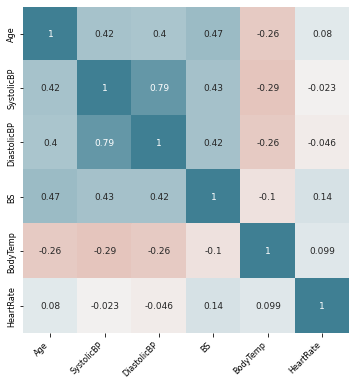

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 9},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)


#### Dependent (Response) variable: RiskLevel (Cualitative)

#####Risk Level frequency

In [34]:
pd.value_counts(data['RiskLevel'])

1.0    406
2.0    336
3.0    272
Name: RiskLevel, dtype: int64

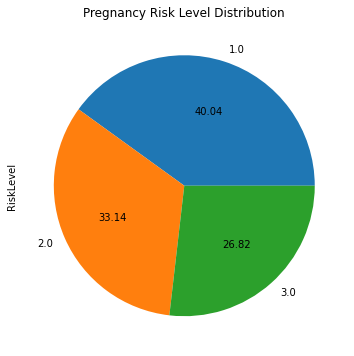

In [35]:
plot = data['RiskLevel'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Pregnancy Risk Level Distribution')

#####Variable distribution per Risk Level

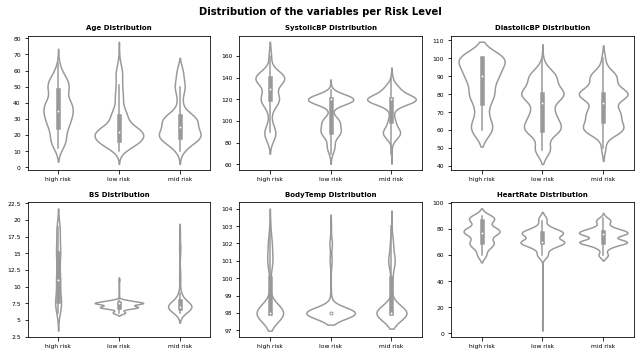

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = data.select_dtypes(include=['float64', 'int']).columns
for i, colum in enumerate(columnas_numeric):
    sns.violinplot(
        x     = 'RiskLevel',
        y     = colum,
        data  = data,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"{colum} Distribution", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribution of the variables per Risk Level', fontsize = 10, fontweight = "bold");

#####Standardization

In [43]:
sc=StandardScaler()
#sc=MinMaxScaler()
data_standard=sc.fit_transform(data2)
data_standard=pd.DataFrame(data_standard)
data_standard.columns=['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
data_standard.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.361738,0.913396,0.255023,1.905890,-0.485215,1.446956
1,0.380777,1.457027,0.975539,1.298340,-0.485215,-0.532088
2,-0.064732,-1.261127,-0.465493,-0.220537,0.973884,0.704815
3,0.009519,1.457027,0.615281,-0.524312,-0.485215,-0.532088
4,0.380777,0.369765,-1.186009,-0.797710,-0.485215,0.210054


In [44]:
data_standard.select_dtypes(include=['float64', 'int']).describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1.014000e+03,1.014000e+03,1.014000e+03,1.014000e+03,1.014000e+03,1.014000e+03
mean,-4.905127e-17,-7.708057e-17,4.694908e-16,-2.137234e-16,2.151249e-15,1.366428e-16
std,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00,1.000493e+00
min,-1.475511e+00,-2.348389e+00,-1.978576e+00,-8.280872e-01,-4.852155e-01,-8.324572e+00
25%,-8.072472e-01,-7.174962e-01,-8.257508e-01,-5.546894e-01,-4.852155e-01,-5.320876e-01
50%,-2.874866e-01,3.697655e-01,2.550228e-01,-3.724243e-01,-4.852155e-01,2.100538e-01
75%,6.777830e-01,3.697655e-01,9.755385e-01,-2.205366e-01,-4.852155e-01,7.048148e-01
max,2.979580e+00,2.544289e+00,1.696054e+00,3.120991e+00,3.162534e+00,1.941717e+00


In [45]:
data['RiskLevel'].replace({"high risk": "3", "mid risk": "2", "low risk" : "1"}, inplace=True)
data['RiskLevel'] = data['RiskLevel'].astype(float)
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,3.0
1,35,140,90,13.0,98.0,70,3.0
2,29,90,70,8.0,100.0,80,3.0
3,30,140,85,7.0,98.0,70,3.0
4,35,120,60,6.1,98.0,76,1.0


In [47]:
data_standard['RiskLevel']=data['RiskLevel']
data_standard.head(4)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,-0.361738,0.913396,0.255023,1.905890,-0.485215,1.446956,3.0
1,0.380777,1.457027,0.975539,1.298340,-0.485215,-0.532088,3.0
2,-0.064732,-1.261127,-0.465493,-0.220537,0.973884,0.704815,3.0
3,0.009519,1.457027,0.615281,-0.524312,-0.485215,-0.532088,3.0


### Random Forest Model

#####Train and Test sample

In [48]:
train, test = train_test_split(data_standard, test_size=0.2, random_state=42)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")

No. of training examples: 811
No. of testing examples: 203


In [49]:
y_test=test['RiskLevel']
x_test=test.drop('RiskLevel', axis=1)
x_test.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
752,-0.064732,0.913396,-0.465493,-0.311669,-0.485215,0.457434
519,0.009519,1.457027,1.696054,1.905890,-0.485215,-0.532088
210,1.494550,1.457027,1.335796,2.513441,-0.485215,-1.768990
611,-0.510241,0.369765,0.975539,-0.372424,-0.485215,-1.768990
914,-0.955750,0.369765,0.255023,-0.372424,2.432984,0.210054


In [50]:
#Setting training data into x_train and y_train
x_train=train.drop('RiskLevel',axis=1)
y_train=train['RiskLevel']

#Shapes of x_train,y_train and test data
x_train.shape, y_train.shape, x_test.shape

((811, 6), (811,), (203, 6))

#####Random Forest Regression

In [51]:
#Random Forest Regression
random_model=RandomForestRegressor(n_estimators=50)
random_model.fit(x_train,y_train)
print(random_model.score(x_train,y_train))

#Making predictions on test set 
random_predict=random_model.predict(x_test)

random_result=pd.DataFrame({'Id':test.index,'Predicted Risk':random_predict,'Actual Risk':y_test})
print(random_result)

0.905141194957237
      Id  Predicted Risk  Actual Risk
752  752        2.000000          2.0
519  519        3.000000          3.0
210  210        3.000000          3.0
611  611        1.056667          1.0
914  914        1.185333          1.0
..   ...             ...          ...
370  370        1.040000          1.0
381  381        1.920000          2.0
780  780        1.980000          2.0
760  760        1.860000          2.0
682  682        3.000000          3.0

[203 rows x 3 columns]


In [52]:
Accuracy_randomforest = np.round(random_model.score(x_train,y_train).mean(),4)
Accuracy_randomforest

0.9051